<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../../../Index.ipynb"><< Index</a>
<br>
<a href="./Statistics_analysis.ipynb" target="_blank"><< Statistics and analysis</a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2023 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Ben Loveday (EUMETSAT/Innoflair UG), Hayley Evers-King (EUMETSAT), Ana Ruescas (Brockmann Consult GmbH / University of Valencia).

<div class="alert alert-block alert-success">
<h3>Liege Colloquium 2023</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
This notebook has the following prerequisites:
- **<a href="https://eoportal.eumetsat.int/" target="_blank">A EUMETSAT Earth Observation Portal account</a>** if you are using or plan to use the EUMETSAT Data Store or CODA

There are no prerequisite notebooks for this module.
</div>
<hr>

## Table of Contents
* [Load S3 image](#Load-S3-image)
* [Show ratio1 band](#Show-ratio1-band)
* [Load the model and make predictions on the S3 image](#Load-the-model-and-make-predictions-on-the-S3-image)
* [Make standard deviation preds with GPR model](#Make-standard-deviation-preds-with-GPR-model)
* [Save preds to `envi`](#Save-preds-to-envi)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
import requests
warnings.filterwarnings("ignore")

from ml import c2_processing, data_load_S3, models

## Load S3 image 
[Table of Contents](#Table-of-Contents)

In [ ]:
urls = ["https://wekeo-files.apps.mercator.dpi.wekeo.eu/s/q8YBojqjqxcQkJZ/download/Support_data.zip"]
for url in urls:
    if not os.path.exists(os.path.basename(url).split('.')[0]):
        r = requests.get(url)
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall(os.path.dirname(os.path.abspath(__file__)))

In [2]:
##Read the images from the S3Images folder (include whole path with directory)
s3image_path = os.path.join(os.getcwd(),'Support_data',"subset_0_of_S3A_OL_1_EFR____20160524T090953_20160524T091153_20170930T000736_0119_004_264______MR1_R_NT_002.data")
img = c2_processing.load_S3_image_C2RCC(image_path=s3image_path)
img.shape

(2049, 1985, 16)

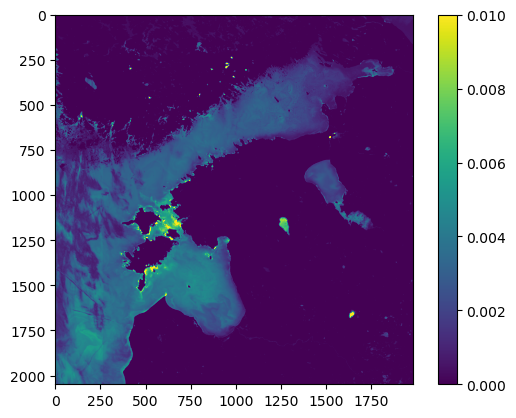

In [3]:
##Plot the image to check that it was read properly
plt.imshow(img[:,:,5],vmin=0,vmax=0.01)
plt.colorbar()
plt.show()

## Load and show water mask
[Table of Contents](#Table-of-Contents)

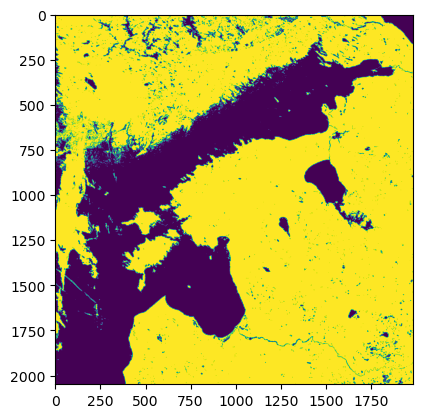

In [4]:
mascara = c2_processing.load_mask_C2RCC(s3image_path)
mascara = (mascara==1)
plt.imshow(mascara)
plt.show()

## Show ratio1 band
[Table of Contents](#Table-of-Contents)

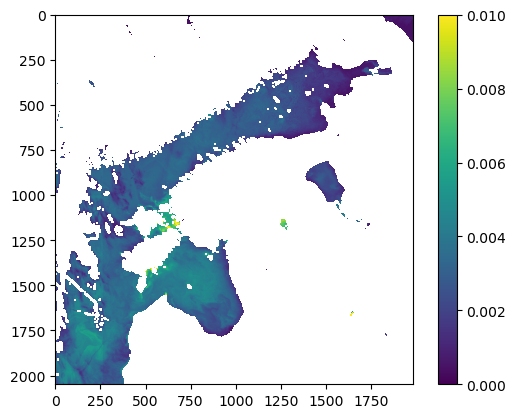

In [5]:
## Show one specific band (ratio1 in the example) with the mask on
ratio = np.ma.masked_array(img[:,:,5],mascara)
plt.imshow(ratio,vmin=0,vmax=0.01)
plt.colorbar()
plt.show()
plt.close()

## Load the model and make predictions on the S3 image
[Table of Contents](#Table-of-Contents)

In [6]:
# Load one of the models stored in the 'models' folder; you need to give the complete name (band combination)
name_model = "RFR"
bands_name = "S3bands"

def load_model(name_model,bands_name):
    file_model = os.path.join(data_load_S3.PATH_TO_MODELS_C2X,
                              name_model+'_'+bands_name+'_CHL.pkl')
    return joblib.load(file_model)

regressor_sklearn = load_model(name_model,bands_name)
regressor_sklearn

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=50))])

In [7]:
# Select the image to predict. band names of model and image should be the same or be correspondent
image_predict = c2_processing.image_to_predict_S3_C2RCC(img,data_load_S3.bands_try_C2X[bands_name])
image_predict.shape

(2049, 1985, 15)

In [8]:
#Optiional: number of pixels that are masked
np.sum(mascara)

2811721

In [9]:
# Load training data to add the mean and compute the min,max range of the predicted variable
_, _, skdata_y_train, _ = data_load_S3.load_C2X()

mean_y_train = np.mean(skdata_y_train)
max_cdom = np.max(skdata_y_train)
predictions = c2_processing.predict_image(image_predict,
                                            mascara,
                                            regressor_sklearn,
                                            y_range=(0,max_cdom),
                                            y_mean=mean_y_train,step=300)                   
predictions.shape

(2049, 1985)

In [10]:
preds = predictions[~np.isnan(predictions)]
preds.max(), preds.min(), preds.mean()

(180.7999999999999, 0.042199999999995796, 11.656086848569215)

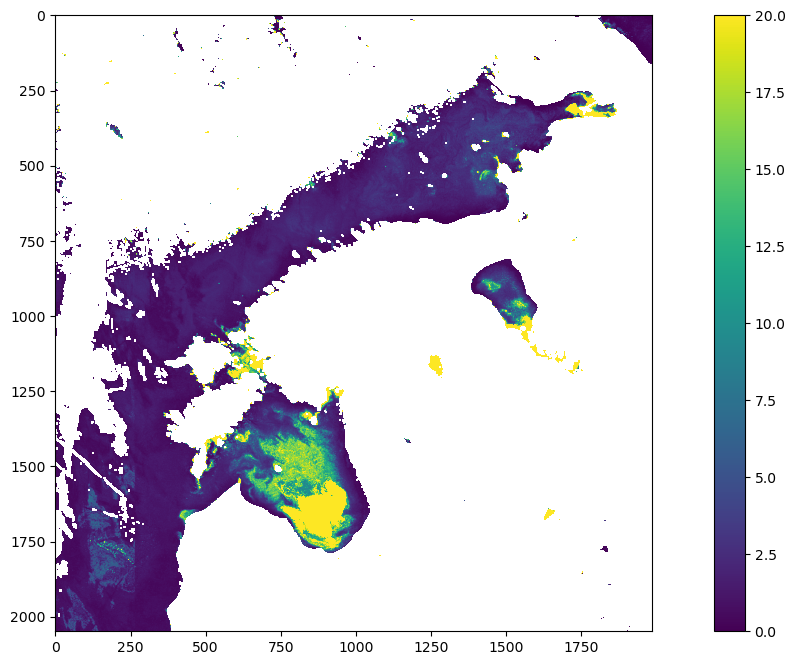

In [11]:
#Show the results of the prediction
plt.figure(figsize=(16,8))
plt.imshow(predictions,vmin=0,vmax=20)
plt.colorbar()
plt.show()

## Save preds to `envi`
[Table of Contents](#Table-of-Contents)

In [12]:
#Save image in envi format (hdr, img) to be opened in SNAP
folder_save = "."
c2_processing.write_envi(predictions, os.path.join(folder_save,
                                                     name_model+'_'+bands_name+'_CHL.hdr'))

<hr>
<a href="../../../Index.ipynb"><< Index</a>
<br>
<a href="./Statistics_analysis.ipynb" target="_blank"><< Statistics and analysis</a>
<hr>
<a href="https://github.com/wekeo/liege-colloquium-23" target="_blank">View on GitHub</a> | <a href="https://training.eumetsat.int/" target="_blank">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int target="_blank">Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int target="_blank">Contact our training team to collaborate on and reuse this material</a></span></p>